In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "mipsel/"
files = os.listdir(path)
len(files)

7551

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [30]:
#path = "mipsel/"

def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [5]:
sample_code_dict = extract_code(path, sample_files)

In [6]:
len(sample_code_dict.keys())

100

In [7]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

24618e365aed55ba1d0c4efb1ef36eea	11040	[66, 0, 28, 60, 216, 255, 189, 39, 128, 224]
748f7f4521886adbef1a9cbd6368aca5	24304	[66, 0, 28, 60, 48, 35, 156, 39, 224, 255]
d2b47fc9a4cc1a5f20842597e84fac5d	77456	[67, 0, 28, 60, 96, 8, 156, 39, 224, 255]
b7385b4c62edaea88472e7c7c08be9ee	199024	[5, 0, 28, 60, 128, 216, 156, 39, 33, 224]
3476aefd563cb1aedf5a8da0bc223753	64640	[1, 0, 16, 4, 0, 0, 0, 0, 3, 0]
5a0deed61aea398f86e0ba901dfdfe45	41376	[67, 0, 28, 60, 32, 128, 156, 39, 224, 255]
000d958959637e4e3a28854544fad5d6	35888	[66, 0, 28, 60, 224, 64, 156, 39, 204, 129]
06916ca61a543beff767d9e52d3d0cd8	133376	[68, 0, 28, 60, 184, 255, 189, 39, 80, 80]
934b176d643d35f82e8ba5f192fbb3e1	16240	[2, 0, 28, 60, 144, 222, 156, 39, 33, 224]
b7a1b5f93e09b4df6831a9a7d470b144	48512	[33, 0, 224, 3, 1, 0, 17, 4, 37, 8]
724456daab602e1c328e3b44f86ce96b	11584	[66, 0, 28, 60, 128, 208, 156, 39, 248, 254]
db21b074da72fd7acf77f72fb74821b2	11696	[66, 0, 28, 60, 16, 208, 156, 39, 96, 255]
ac841144715725285ef09858a3d

In [8]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

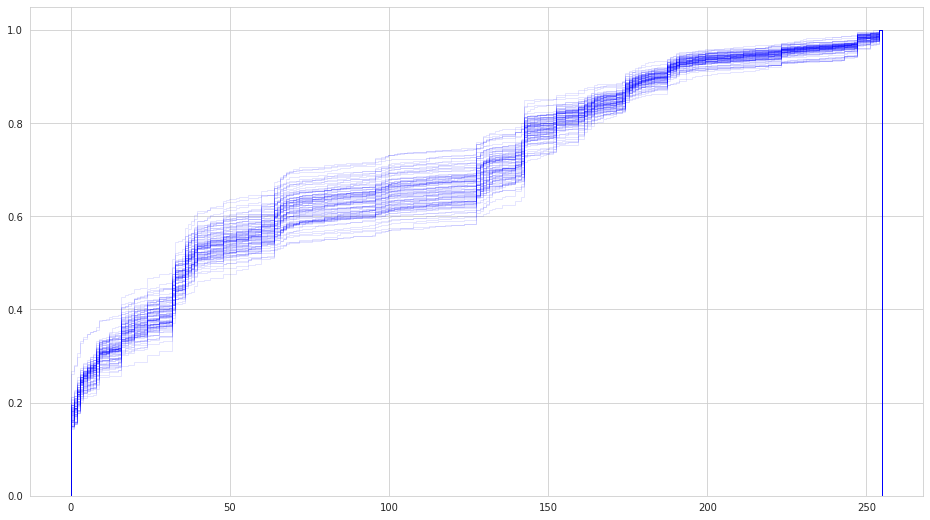

In [9]:
plot_dists(sample_code_dict)

In [10]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [11]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [12]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]


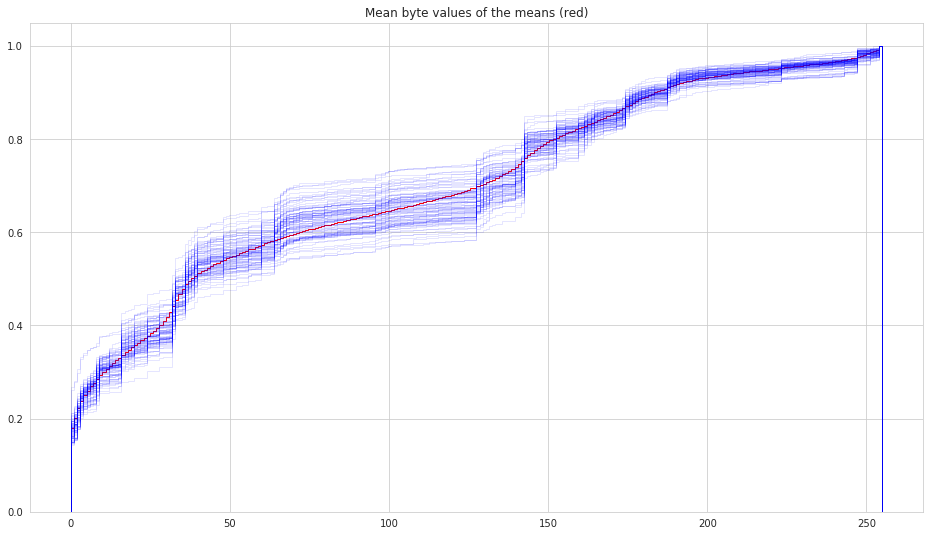

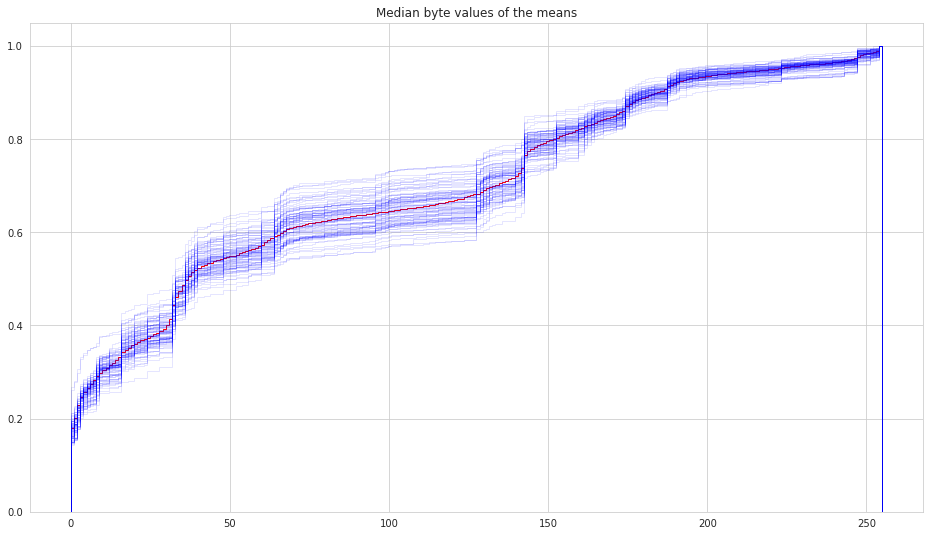

In [13]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

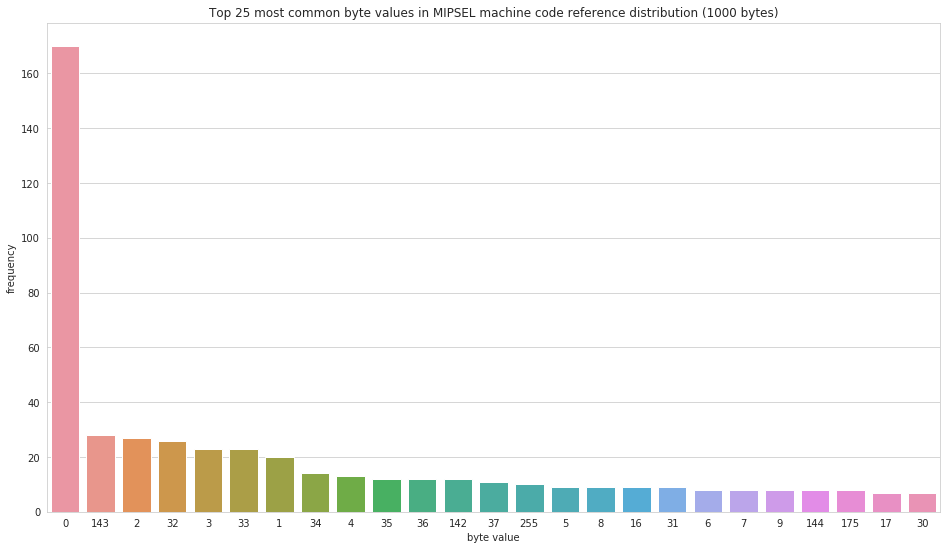

In [31]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in MIPSEL machine code reference distribution (1000 bytes)")
plt.show()

In [15]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0x8f',
 '0x2',
 '0x20',
 '0x3',
 '0x21',
 '0x1',
 '0x22',
 '0x4',
 '0x23',
 '0x24',
 '0x8e',
 '0x25',
 '0xff',
 '0x5',
 '0x8',
 '0x10',
 '0x1f',
 '0x6',
 '0x7',
 '0x9',
 '0x90',
 '0xaf',
 '0x11',
 '0x1e']

In [16]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [17]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [18]:
test_code_dict = extract_code(path, test_files, n_files=1000)

In [19]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

fb182852169ab0d60c1ec0257125bc2d	11232	[80, 254, 189, 39, 66, 0, 28, 60, 140, 1]
1c6671c9f7404b43c4b24d063e17ad5b	18448	[66, 0, 28, 60, 192, 240, 156, 39, 224, 255]
6757ac027d1a863c806f4880de8c8935	138768	[67, 0, 2, 60, 84, 196, 66, 36, 68, 0]
e70eeca82e0ccf4747a51b008c3e4f45	87568	[67, 0, 28, 60, 112, 64, 156, 39, 224, 255]
7d7ba995759ebb2e3de62198fd3975d5	39376	[66, 0, 2, 60, 68, 19, 66, 140, 66, 0]
b00ba35b42092ce20813f7dec113dd77	51168	[33, 0, 224, 3, 1, 0, 17, 4, 0, 0]
8c02a2fc8f64ce7f194cc4c8f60cc6d0	17040	[2, 0, 28, 60, 144, 206, 156, 39, 33, 224]
78f4be1df3d2304d3d5a029399b81dce	314656	[71, 0, 28, 60, 112, 226, 156, 39, 224, 255]
b4a5008c6726a4bc17a6262215f3ca52	120576	[68, 0, 28, 60, 48, 33, 156, 39, 208, 255]
c1c325889e2c1905d80d2f5e5c300562	183536	[5, 0, 28, 60, 96, 96, 156, 39, 33, 224]
0f829af7d81c9c84d1006041dc533e92	65824	[33, 0, 224, 3, 1, 0, 17, 4, 0, 0]
c56647e646996157bdddafbe78c18ed9	25600	[33, 0, 224, 3, 1, 0, 17, 4, 0, 0]
952e686d4c408238d29029c0fa3bd1e1	14592	[66

In [20]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(912, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
fb182852169ab0d60c1ec0257125bc2d,11232,1.64514,0.20712,73.3454,36,76.5239
1c6671c9f7404b43c4b24d063e17ad5b,18448,5.05501,0.529496,69.5747,36,75.0273
6757ac027d1a863c806f4880de8c8935,138768,2.59608,0.283309,75.6031,36,79.1393
e70eeca82e0ccf4747a51b008c3e4f45,87568,6.08407,0.655992,79.5872,40,77.4652
7d7ba995759ebb2e3de62198fd3975d5,39376,3.24198,0.341497,71.4491,36,74.5133
...,...,...,...,...,...,...
e102e7c32982f7c4f8a6306b27497a8c,21264,5.22518,0.549321,69.7226,36,74.0908
3f2ff61ab0e52b0f9d30f130b4c92f6b,33552,8.67891,0.841422,83.2033,40,80.6352
2ea0c660176682e0e34599338921d938,33536,9.66751,0.998326,64.9821,35,71.2234
78b276febc4555eaf80a5fc3bbe92de8,2181440,4.93732,0.586405,79.2915,37,78.0997


In [21]:
test_results_df.mean()

size                    194318.587719
wasserstein distance         5.510948
energy distance              0.592199
mean                        73.784252
median                      37.345943
standard deviation          76.355729
dtype: float64

In [22]:
test_results_df.median()

size                    58320.000000
wasserstein distance        4.883422
energy distance             0.526072
mean                       73.890494
median                     36.000000
standard deviation         76.389393
dtype: float64

In [23]:
test_results_df["size"].sum()

177218552

In [24]:
test_results_df["size"].sum() / 1000000

177.218552

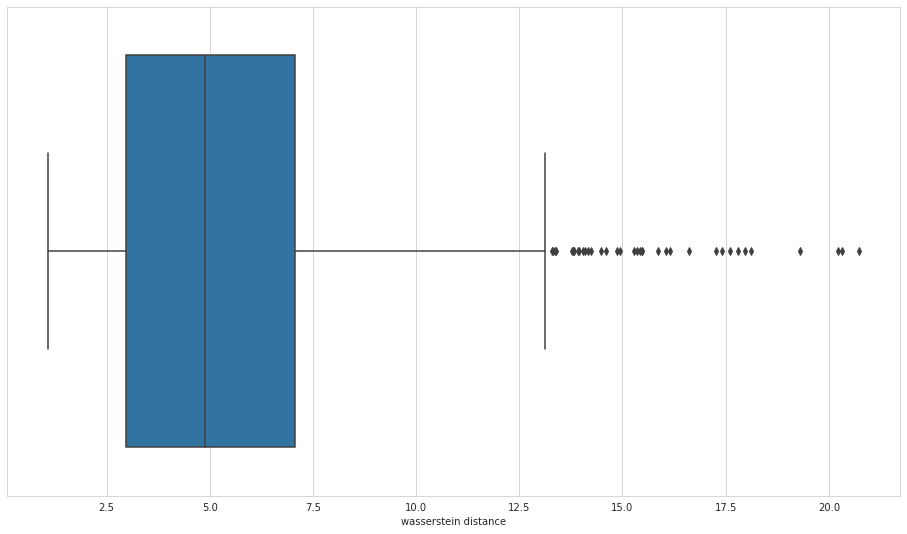

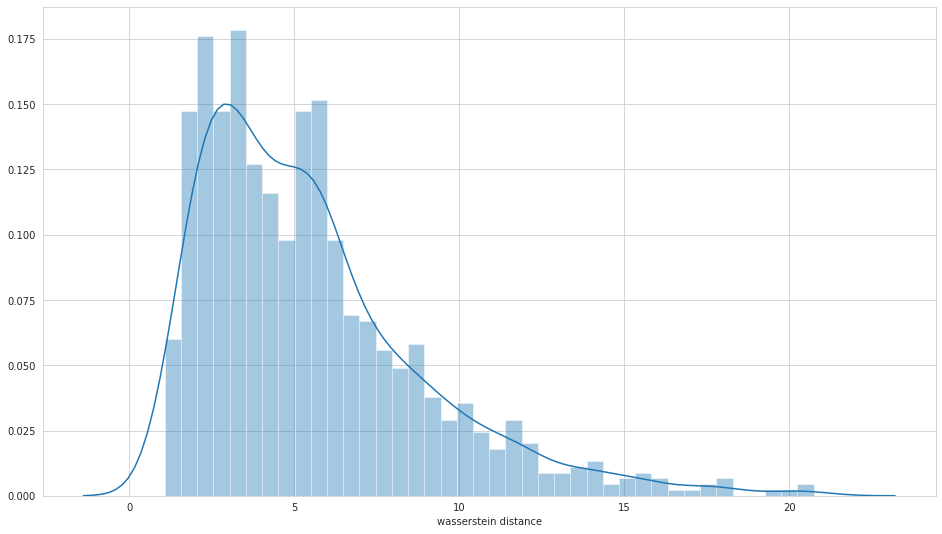

In [25]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

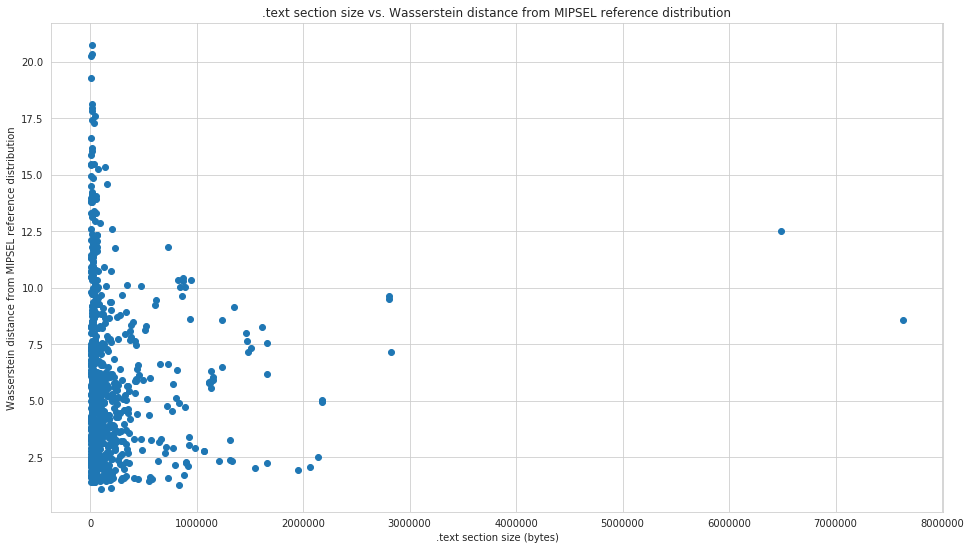

In [28]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from MIPSEL reference distribution")
plt.title(".text section size vs. Wasserstein distance from MIPSEL reference distribution")
plt.show()

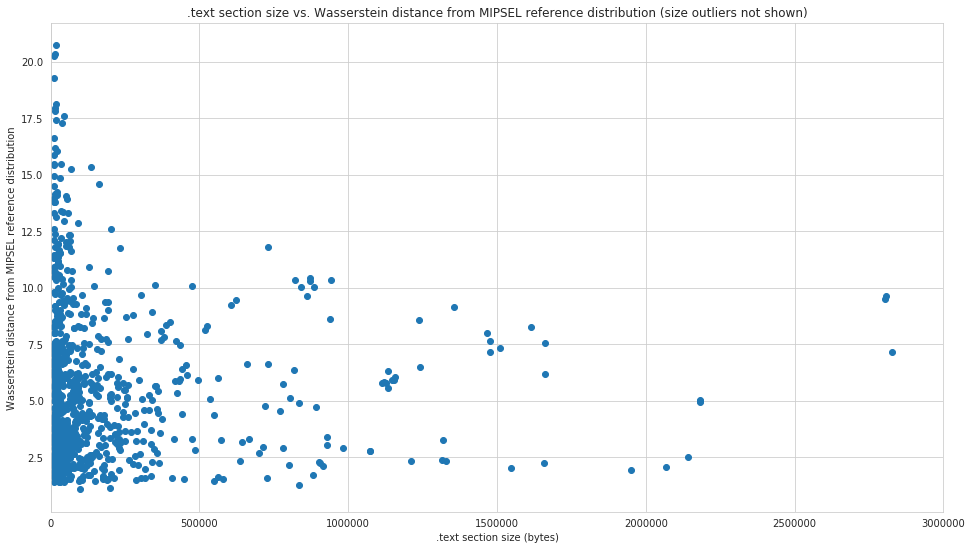

In [32]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from MIPSEL reference distribution")
plt.title(".text section size vs. Wasserstein distance from MIPSEL reference distribution (size outliers not shown)")
plt.xlim(0,3000000)
plt.show()

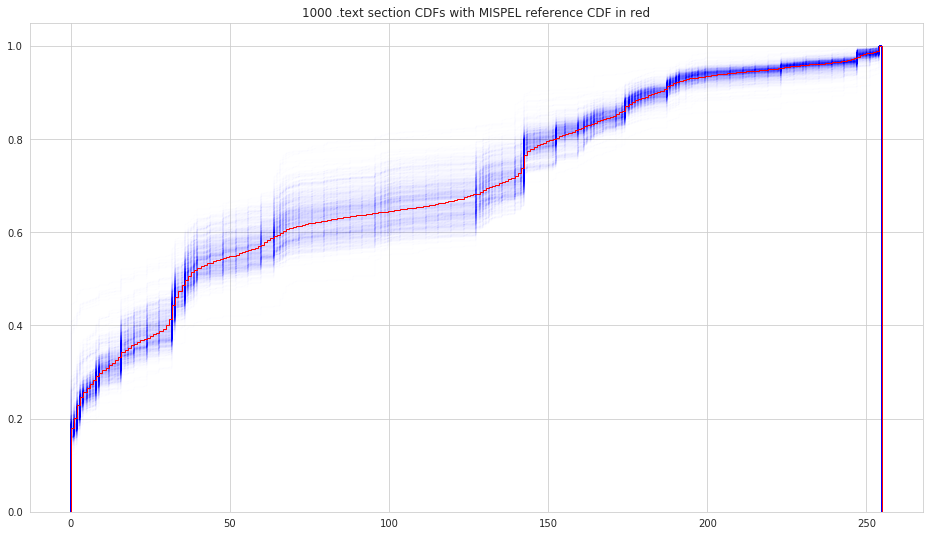

In [33]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with MISPEL reference CDF in red")
plt.show()

In [29]:
# export reference distribution
with open("MIPSEL_reference", "wb") as f:
    pickle.dump(median, f)